# Midterm Project: Diabetes Prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("diabetes_prediction_dataset.csv")

In [3]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


## Checking for Null Values

In [4]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

## Checking the data types

In [5]:
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

**Age should be changed to int**

In [6]:
df["age"] = df["age"].astype("int64")

## Checking unique values for columns that might require cleaning

### For Column "gender":

In [7]:
df["gender"].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

#### Since the value of "Other" is very low, we will replace it with the mode of the column "gender" which is "Female".

In [8]:
df["gender"] = df["gender"].replace({"Other":"Female"})

### For Column "age":

In [9]:
df["age"].unique()

array([80, 54, 28, 36, 76, 20, 44, 79, 42, 32, 53, 78, 67, 15, 37, 40,  5,
       69, 72,  4, 30, 45, 43, 50, 41, 26, 34, 73, 77, 66, 29, 60, 38,  3,
       57, 74, 19, 46, 21, 59, 27, 13, 56,  2,  7, 11,  6, 55,  9, 62, 47,
       12, 68, 75, 22, 58, 18, 24, 17, 25,  0, 33, 16, 61, 31,  8, 49, 39,
       65, 14, 70, 48, 51, 71, 64, 63, 52, 10, 35, 23,  1], dtype=int64)

### For Column "smoking_history":

In [10]:
df["smoking_history"].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

#### We can notice that we have a lot of NaN's and some entries need cleaning. 
1. **"ever" should be replaced with "never"**
2. **"not current" should be replaced with "former"**
3. **Rows containing "No Info" should be dropped since smoking is an important factor that influences the probability of having diabetes and replacing it with the mode or median would skew our results**
4. **Rows the include a value of 0,1,2,3 for column "age" should be dropped.**

In [11]:
df["smoking_history"] = df["smoking_history"].replace({"ever":"never","not current":"former"})

In [12]:
df.drop(df[(df["smoking_history"]=="No Info")].index,inplace=True)

In [13]:
df["smoking_history"].value_counts()

smoking_history
never      39099
former     15799
current     9286
Name: count, dtype: int64

In [14]:
df.drop(df[(df["age"].isin([0,1,2,3]))].index,inplace=True)

### **Reset the index**

In [15]:
df.reset_index(drop=True,inplace=True)

### Saving the cleaned dataset

In [16]:
df.to_csv("cleaned_data.csv")

## Exploring the dataset 

### 1. Plotting our target variable

<Axes: xlabel='diabetes', ylabel='count'>

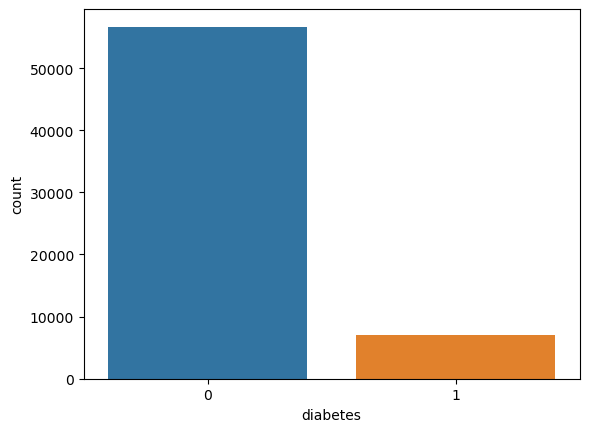

In [17]:
sns.countplot(x="diabetes",data = df)

### We can notice that our dataset is imbalanced. So the XGBoost Classifier will be used since it tackles data imbalance.

### 2. Splitting the dataframe into numerical and categorical

In [18]:
num = df.select_dtypes(["int64","float64"])
cat = df.select_dtypes("object")

### 3. Checking Correlations between the independent numerical continuous variables

In [19]:
num

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,80,0,1,25.19,6.6,140,0
1,28,0,0,27.32,5.7,158,0
2,36,0,0,23.45,5.0,155,0
3,76,1,1,20.14,4.8,155,0
4,20,0,0,27.32,6.6,85,0
...,...,...,...,...,...,...,...
63706,26,0,0,34.34,6.5,160,0
63707,40,0,0,40.69,3.5,155,0
63708,66,0,0,27.83,5.7,155,0
63709,24,0,0,35.42,4.0,100,0


In [20]:
corr = num.loc[:,["age","bmi","HbA1c_level","blood_glucose_level"]].corr()
corr

,age,bmi,HbA1c_level,blood_glucose_level
age,1.000000,0.141985,0.115796,0.117020
bmi,0.141985,1.000000,0.084350,0.094415
HbA1c_level,0.115796,0.084350,1.000000,0.195586
blood_glucose_level,0.117020,0.094415,0.195586,1.000000


### 4. Plotting the heatmap

<Axes: >

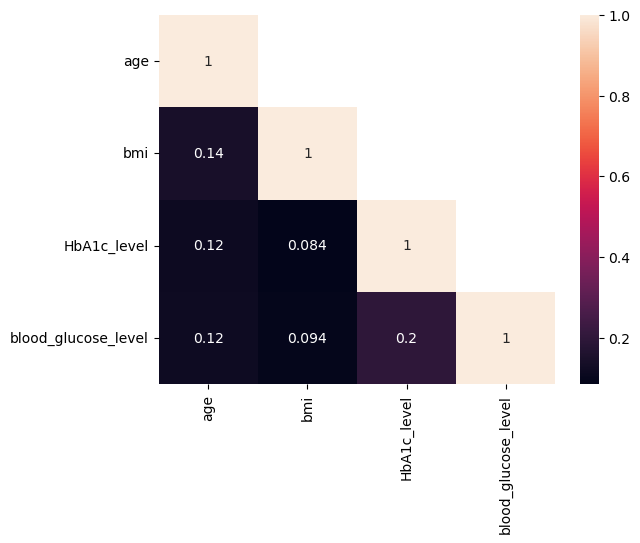

In [43]:
matrix = np.triu(corr)
np.fill_diagonal(matrix,False)
sns.heatmap(corr, annot=True, mask=matrix)

#### Conclusion: No independent numerical variables are highly correlated.

### 5. Checking the distribution of the continuous numerical variables

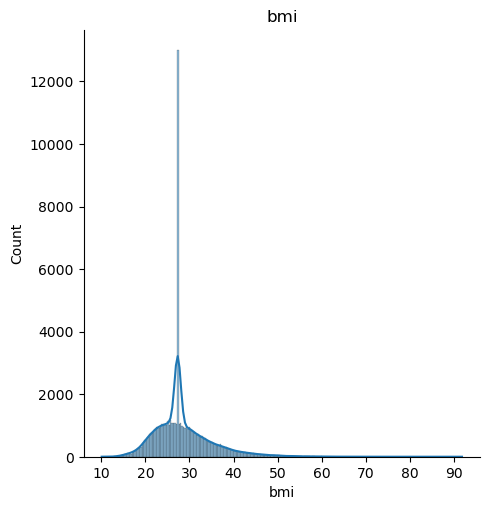

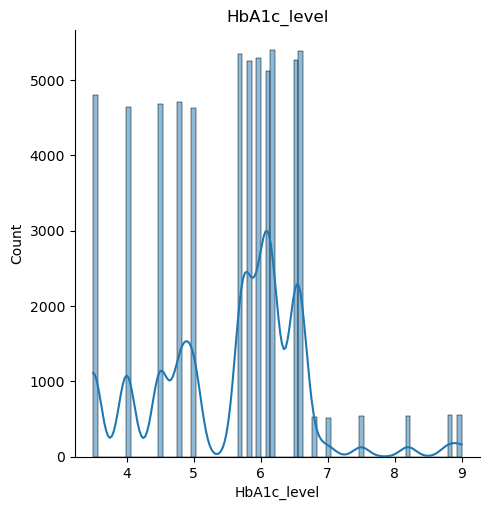

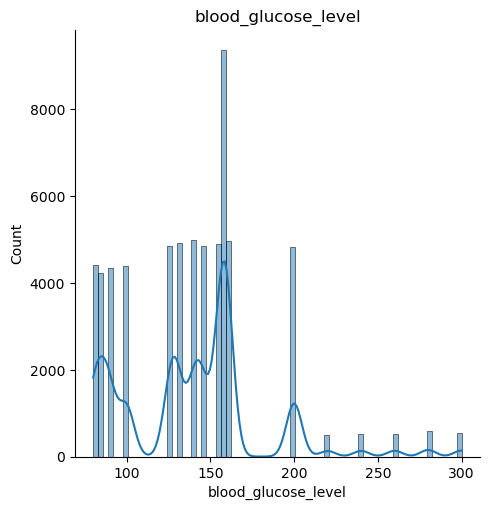

In [22]:
for column in num.columns[3:6]:
    sns.displot(num[column], kde=True)
    plt.title(column)

**Our independent variables do not follow a normal distribution. So, the MinMaxScaler will be used.**

## Transforming the data

**1. Creating dummies for the categorical columns "gender" and "smoking_histroy"**

In [23]:
cat = pd.get_dummies(cat, dtype="int64")

In [24]:
cat

,gender_Female,gender_Male,smoking_history_current,smoking_history_former,smoking_history_never
0,1,0,0,0,1
1,0,1,0,0,1
2,1,0,1,0,0
3,0,1,1,0,0
4,1,0,0,0,1
...,...,...,...,...,...
63706,1,0,0,0,1
63707,1,0,0,0,1
63708,0,1,0,1,0
63709,1,0,0,0,1


**2. Concat our numerical and categorical data**

In [25]:
df_new = pd.concat([num,cat],axis=1)

In [26]:
df_new

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,smoking_history_current,smoking_history_former,smoking_history_never
0,80,0,1,25.19,6.6,140,0,1,0,0,0,1
1,28,0,0,27.32,5.7,158,0,0,1,0,0,1
2,36,0,0,23.45,5.0,155,0,1,0,1,0,0
3,76,1,1,20.14,4.8,155,0,0,1,1,0,0
4,20,0,0,27.32,6.6,85,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
63706,26,0,0,34.34,6.5,160,0,1,0,0,0,1
63707,40,0,0,40.69,3.5,155,0,1,0,0,0,1
63708,66,0,0,27.83,5.7,155,0,0,1,0,1,0
63709,24,0,0,35.42,4.0,100,0,1,0,0,0,1


### Dropping the target variable and storing it into a seperate dataframe (y).

In [27]:
y = df_new[["diabetes"]]

In [28]:
X = df_new.drop(columns="diabetes")

## Splitting the data into test and train and applying XGBoost

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = 42)

## Scaling the Data

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Creating the model using XGBoost

In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [32]:
XG_boost = XGBClassifier(scale_pos_weight= 100, objective = "binary:logistic", n_estimators=500, eval_metric='aucpr',
                         early_stopping_rounds=10, max_depth=8, random_state=42)

model = XG_boost.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)])

[0]	validation_0-aucpr:0.86584
[1]	validation_0-aucpr:0.87085
[2]	validation_0-aucpr:0.87324
[3]	validation_0-aucpr:0.87277
[4]	validation_0-aucpr:0.87433
[5]	validation_0-aucpr:0.87574
[6]	validation_0-aucpr:0.87655
[7]	validation_0-aucpr:0.87652
[8]	validation_0-aucpr:0.87846
[9]	validation_0-aucpr:0.87932
[10]	validation_0-aucpr:0.88513
[11]	validation_0-aucpr:0.88491
[12]	validation_0-aucpr:0.88567
[13]	validation_0-aucpr:0.88636
[14]	validation_0-aucpr:0.88601
[15]	validation_0-aucpr:0.88646
[16]	validation_0-aucpr:0.88594
[17]	validation_0-aucpr:0.88613
[18]	validation_0-aucpr:0.88587
[19]	validation_0-aucpr:0.88428
[20]	validation_0-aucpr:0.88414
[21]	validation_0-aucpr:0.88329
[22]	validation_0-aucpr:0.88322
[23]	validation_0-aucpr:0.88339
[24]	validation_0-aucpr:0.88342
[25]	validation_0-aucpr:0.88347


### Generating our predictions

In [33]:
y_pred = model.predict(X_test_scaled)

### Checking our accuracy score

In [34]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:",(accuracy * 100.0),"%")

Accuracy: 75.00784765093648 %


### Printing a classification report and confusion matrix

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [36]:
rep = classification_report(y_test,y_pred)
print(rep)

              precision    recall  f1-score   support

           0       1.00      0.72      0.84     17035
           1       0.30      0.99      0.46      2079

    accuracy                           0.75     19114
   macro avg       0.65      0.85      0.65     19114
weighted avg       0.92      0.75      0.80     19114



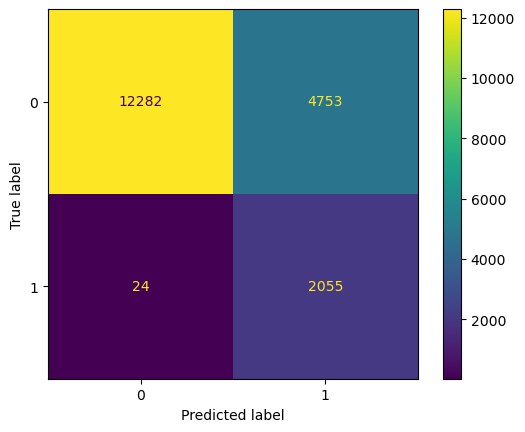

In [37]:
cm = confusion_matrix(y_test, y_pred, labels=XG_boost.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=XG_boost.classes_)
disp.plot()
plt.show()

### Even though this lead to our model accuracy being low, we focused on decreasing the value of false negatives as much as possible (increasing recall) because falsely diagnosing patients who indeed have diabetes is very dangerous.

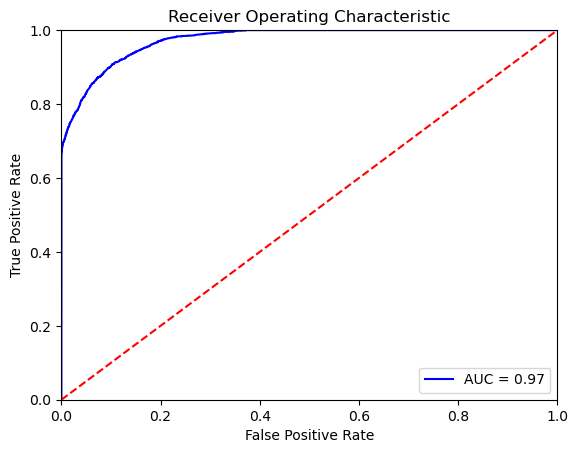

In [38]:
import sklearn.metrics as metrics
probs = model.predict_proba(X_test_scaled)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()